# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

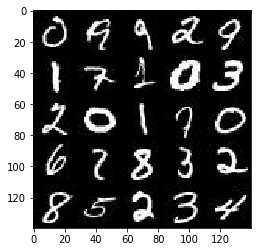

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

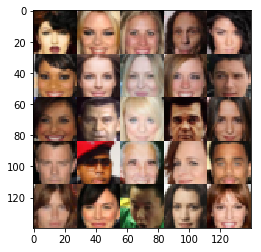

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_input') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, shape=None, name="learning_rate")    
    return (inputs_real, inputs_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        relu3_shape = relu3.get_shape().as_list()
        

        # Flatten it
        flat = tf.reshape(relu3, (-1, relu3_shape[1]*relu3_shape[2]*relu3_shape[3]))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images*2, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})


                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images*2})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 6.6253
Epoch 1/2... Discriminator Loss: 0.7524... Generator Loss: 0.9872
Epoch 1/2... Discriminator Loss: 3.1056... Generator Loss: 0.1654
Epoch 1/2... Discriminator Loss: 2.5417... Generator Loss: 0.1205
Epoch 1/2... Discriminator Loss: 2.2933... Generator Loss: 0.1418
Epoch 1/2... Discriminator Loss: 2.4296... Generator Loss: 0.1282
Epoch 1/2... Discriminator Loss: 1.8709... Generator Loss: 0.2244
Epoch 1/2... Discriminator Loss: 1.8427... Generator Loss: 0.2470
Epoch 1/2... Discriminator Loss: 1.8083... Generator Loss: 0.2561
Epoch 1/2... Discriminator Loss: 1.5580... Generator Loss: 0.3663


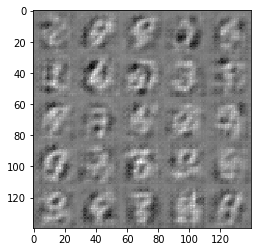

Epoch 1/2... Discriminator Loss: 1.6124... Generator Loss: 0.3203
Epoch 1/2... Discriminator Loss: 1.7385... Generator Loss: 0.2950
Epoch 1/2... Discriminator Loss: 1.5475... Generator Loss: 0.4015
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.3071
Epoch 1/2... Discriminator Loss: 1.4743... Generator Loss: 0.3882
Epoch 1/2... Discriminator Loss: 0.8691... Generator Loss: 0.8232
Epoch 1/2... Discriminator Loss: 1.7285... Generator Loss: 0.2773
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.3710
Epoch 1/2... Discriminator Loss: 1.5695... Generator Loss: 0.3367
Epoch 1/2... Discriminator Loss: 1.7735... Generator Loss: 0.2431


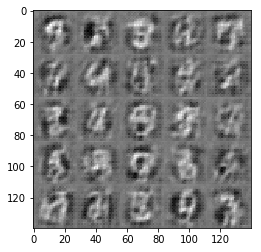

Epoch 1/2... Discriminator Loss: 1.5756... Generator Loss: 0.3327
Epoch 1/2... Discriminator Loss: 1.6118... Generator Loss: 0.3055
Epoch 1/2... Discriminator Loss: 1.5582... Generator Loss: 0.3290
Epoch 1/2... Discriminator Loss: 1.6401... Generator Loss: 0.2699
Epoch 1/2... Discriminator Loss: 1.5930... Generator Loss: 0.3220
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.3497
Epoch 1/2... Discriminator Loss: 1.8429... Generator Loss: 0.2141
Epoch 1/2... Discriminator Loss: 1.6629... Generator Loss: 0.3148
Epoch 1/2... Discriminator Loss: 1.5074... Generator Loss: 0.3618
Epoch 1/2... Discriminator Loss: 1.5508... Generator Loss: 0.3168


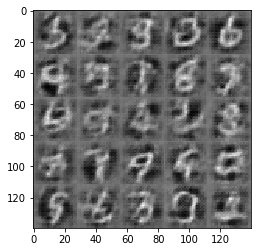

Epoch 1/2... Discriminator Loss: 1.4818... Generator Loss: 0.3664
Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 0.3451
Epoch 1/2... Discriminator Loss: 1.5409... Generator Loss: 0.3231
Epoch 1/2... Discriminator Loss: 1.5770... Generator Loss: 0.3216
Epoch 1/2... Discriminator Loss: 1.6446... Generator Loss: 0.2719
Epoch 1/2... Discriminator Loss: 1.7604... Generator Loss: 0.2770
Epoch 1/2... Discriminator Loss: 1.5723... Generator Loss: 0.3060
Epoch 1/2... Discriminator Loss: 1.9484... Generator Loss: 0.1913
Epoch 1/2... Discriminator Loss: 1.6310... Generator Loss: 0.2820
Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.4516


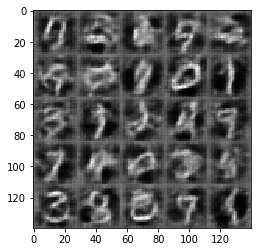

Epoch 1/2... Discriminator Loss: 1.4540... Generator Loss: 0.3793
Epoch 1/2... Discriminator Loss: 1.6898... Generator Loss: 0.2844
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.4854
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 0.3088
Epoch 1/2... Discriminator Loss: 1.5358... Generator Loss: 0.3317
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.4076
Epoch 2/2... Discriminator Loss: 1.5740... Generator Loss: 0.3205
Epoch 2/2... Discriminator Loss: 1.5301... Generator Loss: 0.3709
Epoch 2/2... Discriminator Loss: 1.4945... Generator Loss: 0.3298
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 0.5694


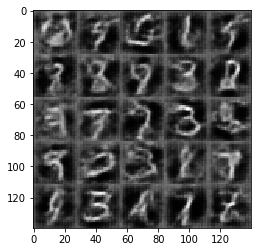

Epoch 2/2... Discriminator Loss: 1.5455... Generator Loss: 0.3157
Epoch 2/2... Discriminator Loss: 1.3686... Generator Loss: 0.3958
Epoch 2/2... Discriminator Loss: 1.5504... Generator Loss: 0.3291
Epoch 2/2... Discriminator Loss: 1.5973... Generator Loss: 0.3104
Epoch 2/2... Discriminator Loss: 1.5992... Generator Loss: 0.3146
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 0.5186
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.3609
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.4441
Epoch 2/2... Discriminator Loss: 1.6741... Generator Loss: 0.2827
Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.4909


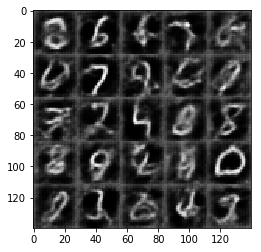

Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 1.4214
Epoch 2/2... Discriminator Loss: 1.2164... Generator Loss: 1.2401
Epoch 2/2... Discriminator Loss: 1.2859... Generator Loss: 1.5197
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 1.3678
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 1.3489
Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 1.4348
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 1.2839
Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 1.0566
Epoch 2/2... Discriminator Loss: 1.1431... Generator Loss: 1.2866


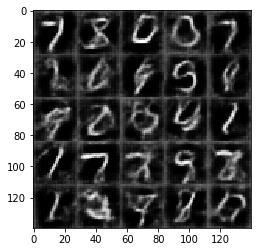

Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 1.4769
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.4189
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.4073
Epoch 2/2... Discriminator Loss: 1.4774... Generator Loss: 0.4312
Epoch 2/2... Discriminator Loss: 1.5023... Generator Loss: 0.3438
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.4515
Epoch 2/2... Discriminator Loss: 1.7072... Generator Loss: 0.2789
Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.3859
Epoch 2/2... Discriminator Loss: 1.5325... Generator Loss: 0.3382
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.4134


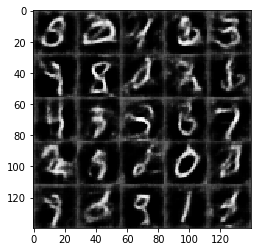

Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.4489
Epoch 2/2... Discriminator Loss: 1.6852... Generator Loss: 0.2746
Epoch 2/2... Discriminator Loss: 1.2949... Generator Loss: 0.4880
Epoch 2/2... Discriminator Loss: 1.4795... Generator Loss: 0.3572
Epoch 2/2... Discriminator Loss: 1.4419... Generator Loss: 0.4065
Epoch 2/2... Discriminator Loss: 1.7381... Generator Loss: 0.2729
Epoch 2/2... Discriminator Loss: 1.5576... Generator Loss: 0.3176
Epoch 2/2... Discriminator Loss: 1.9391... Generator Loss: 0.2312
Epoch 2/2... Discriminator Loss: 1.5719... Generator Loss: 0.3130
Epoch 2/2... Discriminator Loss: 1.6524... Generator Loss: 0.2856


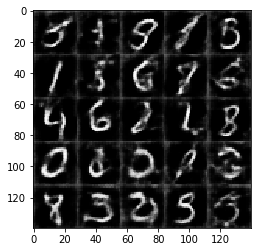

Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 1.3533
Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 1.7310
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.6680


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9697... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 2.3914... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 1.9906... Generator Loss: 1.1477
Epoch 1/1... Discriminator Loss: 1.9247... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.6461... Generator Loss: 1.3529
Epoch 1/1... Discriminator Loss: 1.8707... Generator Loss: 2.0184
Epoch 1/1... Discriminator Loss: 1.6778... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 2.4728... Generator Loss: 0.1271
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.6955


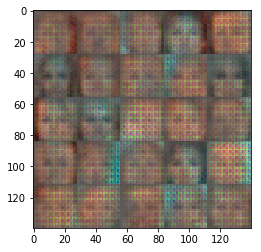

Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.6180... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.9472
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 2.2496... Generator Loss: 2.1715
Epoch 1/1... Discriminator Loss: 0.2784... Generator Loss: 1.6007
Epoch 1/1... Discriminator Loss: 1.9354... Generator Loss: 0.3495
Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.6716


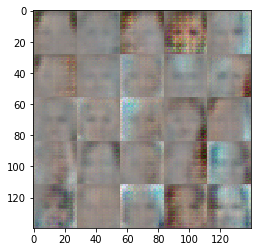

Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.5466


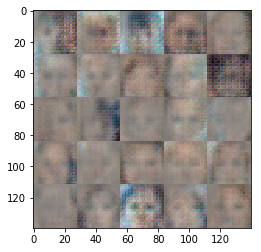

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.6492... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.7398... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6184


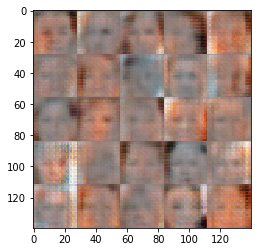

Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.8878... Generator Loss: 0.3911
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7543


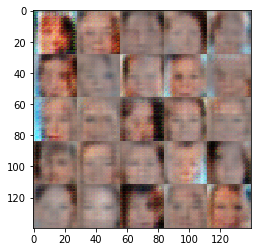

Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6928


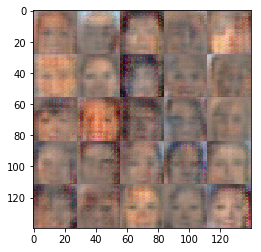

Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6355


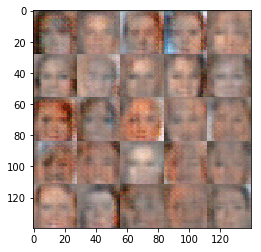

Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6497


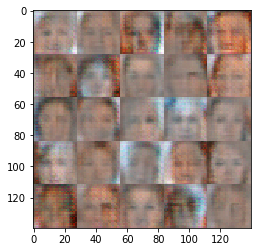

Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.5987


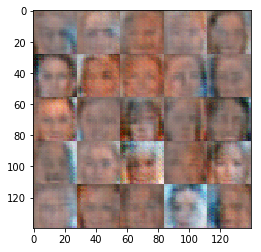

Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7243


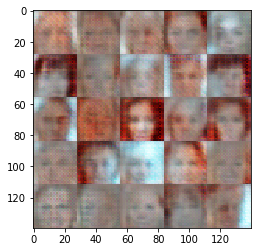

Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5971


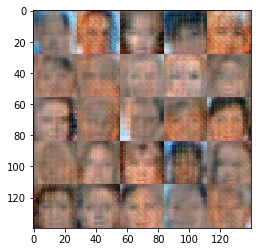

Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6668


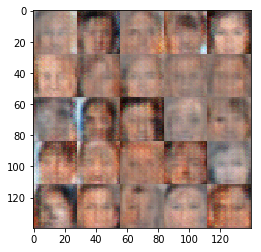

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.7314


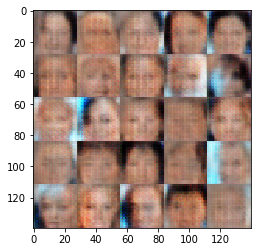

Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.5958


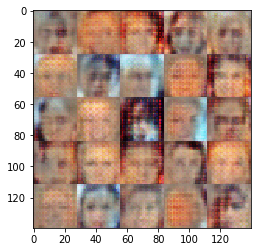

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.5911


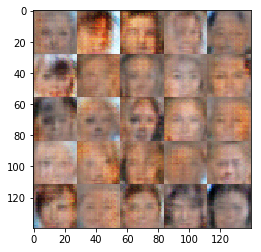

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.3712
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6004


In [25]:
batch_size = 128
z_dim = 250
learning_rate = 0.002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.